<a href="https://colab.research.google.com/github/Seonghoon-Yu/PyTorch_study/blob/main/ch02/ch02_Binary_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('cookbook')

Mounted at cookbook


In [ ]:
# !unzip -n /content/cookbook/MyDrive/data/histopathologic-cancer-detection.zip -d /content/cookbook/MyDrive/data

# unzip 압축파일.zip -d ./폴더명

In [ ]:
cd

/root


In [ ]:
# !ls -l | grep ^- | wc -l

# Check data

In [ ]:
import pandas as pd
# reading train_labels.csv and priniting out its head
path2csv = '/content/cookbook/MyDrive/data/train_labels.csv'
labels_df = pd.read_csv(path2csv)
labels_df.head()

# count the number of normal and malignant cases
# print(labels_df['label'].value_counts())

# look at a histogram of the labels
# labels_df.hist()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


0    130908
1     89117
Name: label, dtype: int64


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7ff789ad5470>]],
      dtype=object)

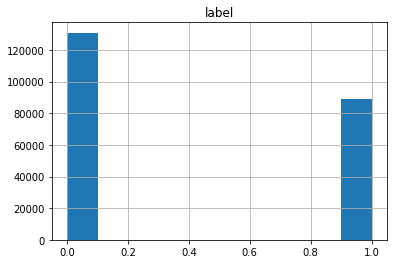

In [ ]:
# count the number of normal and malignant cases
print(labels_df['label'].value_counts())

# look at a histogram of the labels
labels_df.hist()

In [ ]:
# visualize a few images that have a positive label
import matplotlib.pylab as plt
from PIL import Image, ImageDraw
import cv2
import numpy as np
import os

# get ids for malignant images
malignantIds = labels_df.loc[labels_df['label']==1]['id'].values

# data is stored here
path2train = '/content/cookbook/MyDrive/data/train/'

# show images in grayscale, if you want color change it to True
color = False

plt.rcParams['figure.figsize'] = (10.0, 10.0)
plt.subplots_adjust(wspace=0, hspace=0)
nrows, ncols = 3, 3

print(malignantIds[:9])
for i,id_ in enumerate(malignantIds[:nrows*ncols]):
    full_filenames = os.path.join(path2train, id_ + '.tif')

    # load image
    img = Image.open(full_filenames)

    # draw a 32*32 rectangle
    draw = ImageDraw.Draw(img)
    draw.rectangle(((32,32),(64,64)),outline='green')
    plt.subplot(nrows, ncols, i+1)
    if color is True:
        plt.imshow(np.array(img))
    else:
        plt.imshow(np.array(img)[:,:,0],cmap='gray')
    plt.axis('off')

# get the image's shape and minimum and maximum pixel values
print('image shape:', np.array(img).shape) 
print('pixel values range from %s to %s' %(np.min(img), np.max(img)))



['c18f2d887b7ae4f6742ee445113fa1aef383ed77'
 'a24ce148f6ffa7ef8eefb4efb12ebffe8dd700da'
 '7f6ccae485af121e0b6ee733022e226ee6b0c65f'
 'c3d660212bf2a11c994e0eadff13770a9927b731'
 '94fa32b29cc1c00403176c0795fffa3cfaa0f20e'
 '0b820b71670c039dd0a51333d1c919f471a9e940'
 'd34af1e7500f2f3de41b0e6fdeb2ed245d814590'
 '464327050ef07bb927f8bfb5c4e4dd5ebd4d3c09'
 '6961bdcc16f6c1d7db88fc6a7823178288c2a29e']


OSError: ignored

<Figure size 720x720 with 0 Axes>

# creating a custom dataset

In [ ]:
from PIL import Image
import torch
from torch.utils.data import Dataset

# fix torch random seed
torch.manual_seed(0)

class histoCancerDataset(Dataset):
    def __init__(self, data_dir, transform, data_type='train'):
        # path to images
        path2data = os.path.join(data_dir, data_type)

        # get a list of images
        filenames = os.listdir(path2data)

        # get the full path to images
        self.full_filenames = [os.path.join(path2data, f) for f in filenames]

        # labels are in a csv file named train_labels.csv
        csv_filename = data_type + '_labels.csv'
        path2csvLabels = os.path.join(data_dir, csv_filename)
        labels_df = pd.read_csv(path2csvLabels)

        # set data frame index to id
        labels_df.set_index('id', inplace=True)

        # obtain labels from data frame
        self.labels = [labels_df.loc[filename[:-4]].values[0] for filename in filenames]

        self.transform = transform

    def __len__(self):
        # return size of dataset
        return len(self.full_filenames)

    def __getitem__(self, idx):
        # open image, apply transforms and return with label
        image = Image.open(self.full_filenames[idx])
        image = self.transform(image)
        return image, self.labels[idx]

# define a simple transformation that only converts a PIL image into PyTorch tensors
import torchvision.transforms as transforms
data_transformer = transforms.Compose([transforms.ToTensor()])

# define an object of the custom dataset for the train folder
data_dir ='/content/cookbook/MyDrive/data'
histo_dataset = histoCancerDataset(data_dir, data_transformer, 'train')

print(len(histo_dataset))

# load an image
img, label = histo_dataset[9]
print(img.shape, torch.min(img), torch.max(img))



220025
torch.Size([3, 96, 96]) tensor(0.) tensor(1.)


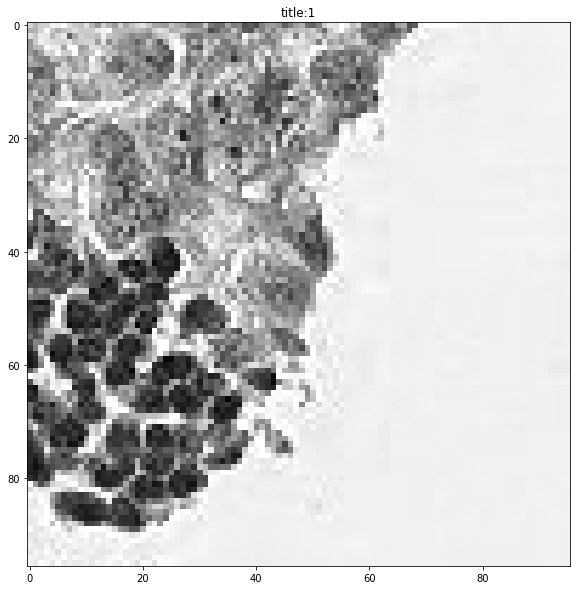

In [ ]:
show(img, label)

# Splitting the dataset

In [ ]:
# split histo_dataset
from torch.utils.data import random_split

len_histo = len(histo_dataset)
len_train = int(0.8 * len_histo)
len_val = len_histo - len_train

train_ds, val_ds = random_split(histo_dataset,[len_train, len_val])

print('train dataset length:', len(train_ds))
print('val dataset length', len(val_ds))

train dataset length: 176020
val dataset length 44005


In [ ]:
# get an image from the training dataset
for x, y in train_ds:
    print(x.shape, y)
    break

# get an image from the validation dataset
for x, y in val_ds:
    print(x.shape, y)
    break


torch.Size([3, 96, 96]) 1
torch.Size([3, 96, 96]) 1


image indices: [ 43567 173685 117952 152315]
torch.Size([3, 100, 394])


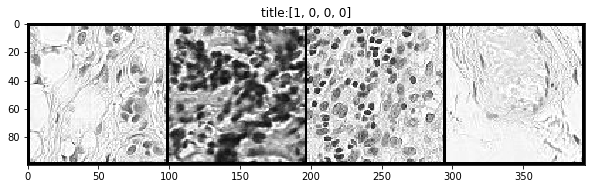

In [ ]:
# display a few samples from train_ds
# import the required packages
from torchvision import utils
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
np.random.seed(0)

# define a helper function to show an image
def show(img, y, color=False):
    # convert tensor to numpy array
    npimg = img.numpy()

    # Convert to H*W* shape
    npimg_tr = np.transpose(npimg, (1,2,0))

    if color == False:
        npimg_tr = npimg_tr[:,:,0]
        plt.imshow(npimg_tr, interpolation='nearest', cmap='gray')
    else:
        plt.imshow(npimg_tr, interpolation='nearest')
    plt.title('title:' + str(y))

# create a grid of sample images
grid_size = 4
rnd_inds = np.random.randint(0, len(train_ds), grid_size)
print('image indices:', rnd_inds)

x_grid_train = [train_ds[i][0] for i in rnd_inds]
y_grid_train = [train_ds[i][1] for i in rnd_inds]

x_grid_train = utils.make_grid(x_grid_train, nrow=4, padding=2)
print(x_grid_train.shape)

# call the helper function to display the grid
plt.rcParams['figure.figsize'] = (10.0, 5)
show(x_grid_train, y_grid_train)

Image indices: [30403 32103 41993 20757]
torch.Size([3, 100, 394])


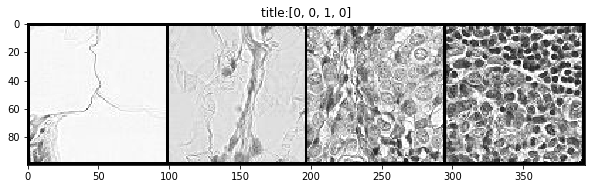

In [ ]:
# we can also show a few samples from val_ds
grid_size = 4
rnd_inds = np.random.randint(0, len(val_ds), grid_size)
print('Image indices:', rnd_inds)
x_grid_val = [val_ds[i][0] for i in rnd_inds]
y_grid_val = [val_ds[i][1] for i in rnd_inds]

x_grid_val = utils.make_grid(x_grid_val, nrow=grid_size, padding=2)
print(x_grid_val.shape)

show(x_grid_val, y_grid_val)


# Transforming the data

In [ ]:
# define the transformation for the training dataset
train_transformer = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(45),
    transforms.RandomResizedCrop(96, scale=(0.8, 1.0), ratio=(1.0, 1.0)),
    transforms.ToTensor()])

# define the transformation for the validation dataset
val_transformer = transforms.Compose([transforms.ToTensor()])

# overwrite the transform functions of train_ds and val_ds
train_ds.transform = train_transformer
val_ds.transform = val_transformer

# Creating dataloaders

In [ ]:
from torch.utils.data import DataLoader

train_dl = DataLoader(train_ds, batch_size=32, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=64, shuffle=False)

# Building the classification model

In [ ]:
# # create dumb baselines for the validation dataset

# # get labels for validation dataset
# y_val = []
# for _, val in val_dl:
#     y_val.append(val)

# # define a function to calculater the classification accuracy
# def accuracy(labels, out):
#     return np.sum(out==labels / len(labels))

# # accuracy all zero predictions
# acc_all_zeros = accuracy(y_val, np.zeros_like(y_val))
# print('accuracy all zero prediction: %.2f' %acc_all_zeros)

# # accuracy all ones predictions
# acc_all_ones = accuracy(y_val, np.ones_like(y_val))
# print('accuracy all ones prediction: %.2f' %acc_all_ones)

# # accuracy random predictions
# acc_random = accuracy(y_val, np.random.randint(2,size=len(y_val)))
# print('accuracy random predictions: %.2f' %acc_random)

In [ ]:
# implement a helper function to calculate the output size of a CNN layer
import torch.nn as nn
import numpy as np

# define the helper function
def findConv2dOutShape(H_in, W_in, conv, pool=2):
    # get conv arguments
    kernel_size = conv.kernel_size
    stride = conv.stride
    padding = conv.padding
    dilation = conv.dilation

    H_out = np.floor((H_in + 2*padding[0] - dilation[0]*(kernel_size[0]-1)-1) / stride[0] + 1)
    W_out = np.floor((W_in + 2*padding[1] - dilation[1]*(kernel_size[1]-1)-1) / stride[1] + 1)

    if pool:
        H_out /= pool
        W_out /= pool
    
    return int(H_out), int(W_out)

# look at the helper function using an example
conv1 = nn.Conv2d(3, 8, kernel_size=3)
h,w = findConv2dOutShape(96,96,conv1)
print(h,w)

47 47


In [ ]:
# implement the CNN model
import torch.nn as nn
import torch.nn.functional as F

# define the Net class
class Net(nn.Module):
    def __init__(self, params):
        super(Net, self).__init__()
        C_in, H_in, W_in = params['input_shape']
        init_f = params['initial_filters']
        num_fc1 = params['num_fc1']
        num_classes = params['num_classes']
        self.dropout_rate = params['dropout_rate']

        self.conv1 = nn.Conv2d(C_in, init_f, kernel_size=3)
        h,w = findConv2dOutShape(H_in, W_in, self.conv1)
        self.conv2 = nn.Conv2d(init_f, 2*init_f, kernel_size=3)
        h,w = findConv2dOutShape(h, w, self.conv2)
        self.conv3 = nn.Conv2d(2*init_f, 4*init_f, kernel_size=3)
        h,w = findConv2dOutShape(h, w, self.conv3)
        self.conv4 = nn.Conv2d(4*init_f, 8*init_f, kernel_size=3)
        h,w = findConv2dOutShape(h, w, self.conv4)

        # computer the flatten size
        self.num_flatten = h*w*8*init_f
        self.fc1 = nn.Linear(self.num_flatten, num_fc1)
        self.fc2 = nn.Linear(num_fc1, num_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv3(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv4(x))
        x = F.max_pool2d(x, 2, 2)

        x = x.view(-1, self.num_flatten)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, self.dropout_rate, training = self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

# dict to define model parameters
params_model = {
    'input_shape': (3, 96, 96),
    'initial_filters': 8,
    'num_fc1': 100,
    'dropout_rate': 0.25,
    'num_classes': 2,
    }

# create model
cnn_model = Net(params_model)
if torch.cuda.is_available():
    device = torch.device('cuda')
    cnn_model = cnn_model.to(device)

print(cnn_model)
print(next(cnn_model.parameters()).device)

Net(
  (conv1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=1024, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=2, bias=True)
)
cuda:0


In [ ]:
# get a summary of the model
from torchsummary import summary
summary(cnn_model, input_size=(3, 96, 96), device=device.type)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 94, 94]             224
            Conv2d-2           [-1, 16, 45, 45]           1,168
            Conv2d-3           [-1, 32, 20, 20]           4,640
            Conv2d-4             [-1, 64, 8, 8]          18,496
            Linear-5                  [-1, 100]         102,500
            Linear-6                    [-1, 2]             202
Total params: 127,230
Trainable params: 127,230
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.11
Forward/backward pass size (MB): 0.92
Params size (MB): 0.49
Estimated Total Size (MB): 1.51
----------------------------------------------------------------


# Defining the loss function

In [ ]:
# define the loss function
loss_func = nn.NLLLoss(reduction='sum')

# use the loss in an example
# fix random seed
torch.manual_seed(0)

n, c = 8, 2
y = torch.randn(n, c, requires_grad=True)
ls_F = nn.LogSoftmax(dim=1)
y_out=ls_F(y)
print(y_out.shape)

target = torch.randint(c, size=(n,))
print(target.shape)

loss = loss_func(y_out, target)
print(loss.item())

# computer the gradients of the loss with respect to y
loss.backward()
print(y.data)

torch.Size([8, 2])
torch.Size([8])
5.266995429992676
tensor([[-1.1258, -1.1524],
        [-0.2506, -0.4339],
        [ 0.8487,  0.6920],
        [-0.3160, -2.1152],
        [ 0.3223, -1.2633],
        [ 0.3500,  0.3081],
        [ 0.1198,  1.2377],
        [ 1.1168, -0.2473]])


# Defining the optimizaer

In [ ]:
# define an object of the Adam optimizer with a learning rate of 3e-4
from torch import optim
opt = optim.Adam(cnn_model.parameters(), lr=3e-4)

# read the current value of the learning rate using the following fuction
def get_lr(opt):
    for param_group in opt.param_groups:
        return param_group['lr']

current_lr = get_lr(opt)
print('current lr={}'.format(current_lr))

current lr=0.0003


In [ ]:
# define a learning scheduler using the ReduceLROnPlateau method
from torch.optim.lr_scheduler import ReduceLROnPlateau

# define learning rate scheduler
lr_scheduler = ReduceLROnPlateau(opt, mode='min', factor=0.5, patience=20, verbose=1)

# example
for i in range(100):
    lr_scheduler.step(1)

Epoch    22: reducing learning rate of group 0 to 1.5000e-04.
Epoch    43: reducing learning rate of group 0 to 7.5000e-05.
Epoch    64: reducing learning rate of group 0 to 3.7500e-05.
Epoch    85: reducing learning rate of group 0 to 1.8750e-05.


# Training and evaluation of the model

In [ ]:
# develop a helper function to count the number of correct predictions per data batch
def metrics_batch(output, target):
    # get output class
    pred = output.argmax(dim=1, keepdim=True)
    # compare output class with target class
    corrects = pred.eq(target.view_as(pred)).sum().item()
    return corrects

# develop a helper function to computer the loss value per batch of data
def loss_batch(loss_func, output, target, opt=None):
    loss = loss_func(output, target)
    with torch.no_grad():
        metric_b = metrics_batch(output, target)
    if opt is not None:
        opt.zero_grad()
        loss.backward()
        opt.step()
    return loss.item(), metric_b

# develop a helper function to compute the loss value and the performance metric for the entire dataset, also called an epoch
def loss_epoch(model, loss_func, dataset_dl, sanity_check=False, opt=None):
    running_loss = 0.0
    running_metric = 0.0
    len_data = len(dataset_dl.dataset)

    for xb, yb in dataset_dl:
        # move batch to device
        xb = xb.to(device)
        yb = yb.to(device)
        # get model output
        output = model(xb)
        # get loss per batch
        loss_b, metric_b = loss_batch(loss_func, output, yb, opt)

        # update running loss
        running_loss += loss_b
        # udate running metric
        if metric_b is not None:
            running_metric += metric_b

        # break the loop in case of sanity check
        if sanity_check is True:
            break
        
    # average loss value
    loss = running_loss / float(len_data)
    # average metric value
    metric = running_metric / float(len_data)
    return loss, metric

In [ ]:
# develop train_val function
def train_val(model, params):
    # extract model parameters
    num_epochs = params['num_epochs']
    loss_func = params['loss_func']
    opt = params['optimizer']
    train_dl = params['train_dl']
    val_dl = params['val_dl']
    sanity_check = params['sanity_check']
    lr_scheduler = params['lr_scheduler']
    path2weights = params['path2weights']
    
    # define two dictionaries to keep a history of the loss and accuracy values
    # history of loss values in each epoch
    loss_history = {
        'train':[],
        'val':[],
    }

    # history of metric values in each epoch
    metric_history = {
        'train': [],
        'val': [],
    }

    # create a copy of state_dict
    # a deep copy of weights for the best performing model
    best_model_wts = copy.deepcopy(model.state_dict())

    # initialize the best loss to an infinite value
    best_loss = float('inf')

    # define a loop that will calculate the training loss over an epoch
    # main loop
    for epoch in range(num_epochs):
        # get current learning rate
        current_lr = get_lr(opt)
        print('Epoch {}/{}, current lr={}'.format(epoch, num_epochs-1, current_lr))

        # train model on training dataset
        model.train()
        train_loss, train_metric = loss_epoch(model, loss_func, train_dl, sanity_check, opt)

        # collect loss and metric for training dataset
        loss_history['train'].append(train_loss)
        metric_history['train'].append(train_metric)

        # evaluate model on validation dataset
        model.eval()
        with torch.no_grad():
            val_loss, val_metric = loss_epoch(model, loss_func, val_dl, sanity_check)
        
        # collect loss and metric for validation dataset
        loss_history['val'].append(val_loss)
        metric_history['val'].append(val_metric)

        # store the best model
        if val_loss < best_loss:
            best_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            # store weights into a local file
            torch.save(model.state_dict(), path2weights)
            print('Copied best model weights!')
        
        # update the learning rate
        lr_scheduler.step(val_loss)
        if current_lr != get_lr(opt):
            print('Loading best model weights!')
            model.load_state_dict(best_model_wts)
        
        # print the loss and accuracy values and return the trained model
        print('train loss: %.6f, dev loss: %.6f, accuracy: %.2f' %(train_loss, val_loss, 100*val_metric))
        print('-'*10)

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, loss_history, metric_history

In [ ]:
# set the sanity_check fkag to True and run the code
# define objects for the optimization, loss, and learning rate schedule
import copy
import os
loss_func = nn.NLLLoss(reduction='sum')
opt = optim.Adam(cnn_model.parameters(), lr=3e-4)
lr_scheduler = ReduceLROnPlateau(opt, mode='min', factor=0.5, patience=20, verbose=1)

def createFolder(directory):
    try:
        if not os.path.exists(directory):
            os.makedirs(directory)
    except OSerror:
        print('Error')
createFolder('./models')

# define the training parameters and call the train_val helper function
params_train = {
    'num_epochs':100,
    'optimizer':opt,
    'loss_func':loss_func,
    'train_dl':train_dl,
    'val_dl':val_dl,
    'sanity_check':True,
    'lr_scheduler':lr_scheduler,
    'path2weights':'./models/weights.pt',
}

# train and validate the model
cnn_model, loss_hist,metric_hist = train_val(cnn_model, params_train)

Epoch 0/99, current lr=0.0003
Copied best model weights!
train loss: 0.000079, dev loss: 0.000687, accuracy: 0.11
----------
Epoch 1/99, current lr=0.0003
train loss: 0.000113, dev loss: 0.000723, accuracy: 0.11
----------
Epoch 2/99, current lr=0.0003
train loss: 0.000093, dev loss: 0.000745, accuracy: 0.11
----------
Epoch 3/99, current lr=0.0003
train loss: 0.000093, dev loss: 0.000771, accuracy: 0.11
----------
Epoch 4/99, current lr=0.0003
train loss: 0.000096, dev loss: 0.000750, accuracy: 0.11
----------
Epoch 5/99, current lr=0.0003
train loss: 0.000103, dev loss: 0.000707, accuracy: 0.11
----------
Epoch 6/99, current lr=0.0003
Copied best model weights!
train loss: 0.000076, dev loss: 0.000657, accuracy: 0.11
----------
Epoch 7/99, current lr=0.0003
Copied best model weights!
train loss: 0.000102, dev loss: 0.000619, accuracy: 0.12
----------
Epoch 8/99, current lr=0.0003
Copied best model weights!
train loss: 0.000090, dev loss: 0.000617, accuracy: 0.12
----------
Epoch 9/99

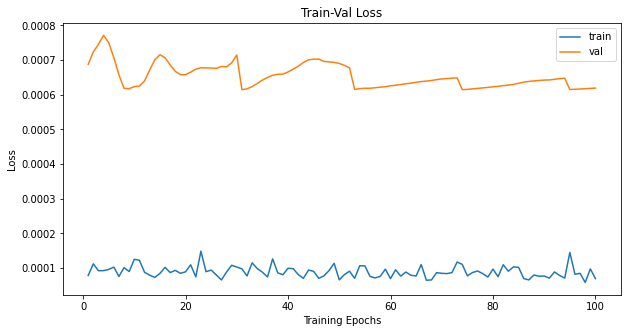

<function matplotlib.pyplot.show>

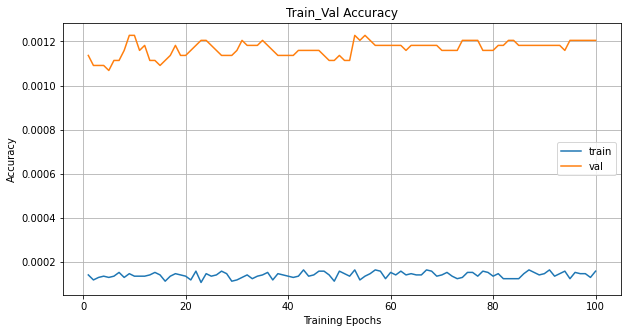

In [ ]:
# plot the training validation's progress using the returned values

# Train-Validation Progess
num_epochs = params_train['num_epochs']

# plot loss progress
plt.title('Train-Val Loss')
plt.plot(range(1, num_epochs+1), loss_hist['train'], label='train')
plt.plot(range(1, num_epochs+1), loss_hist['val'], label='val')
plt.ylabel('Loss')
plt.xlabel('Training Epochs')
plt.legend()
plt.show()

# plot accuracy progress
plt.title('Train_Val Accuracy')
plt.plot(range(1, num_epochs+1), metric_hist['train'], label='train')
plt.plot(range(1, num_epochs+1), metric_hist['val'], label='val')
plt.ylabel('Accuracy')
plt.xlabel('Training Epochs')
plt.legend()
plt.grid()
plt.show

# Deploying the model

In [ ]:
# model parameters
params_model = {
    'input_shape': (3, 96, 96),
    'initial_filters': 8,
    'num_fc1': 100,
    'dropout_rate': 0.25,
    'num_classes': 2,
}

# initialize model
cnn_model = Net(params_model)

# load state_dict into the model
path2weights = './models/weights.pt'
cnn_model.load_state_dict(torch.load(path2weights))

# set the model in eval mode
cnn_model.eval()

# move model to cuda/gpu device
if torch.cuda.is_available():
    device = torch.device('cuda')
    cnn_model = cnn_model.to(device)

# develop a helper function to deploy the model on a dataset
def deploy_model(model, dataset, device, num_classes=2, sanity_check=True):
    len_data = len(dataset)
    # initialize output tensor on CPU: due to GPU memoty limits
    y_out = torch.zeros(len_data, num_classes)
    # initialize ground truth on CPU: due to GPU memory limits
    y_gt = np.zeros((len_data), dtype='unit8')
    # move model to device
    model = model.to(device)

    elapsed_times = []
    with torch.no_grad():
        for i in range(len_data):
            x, y = dataset[i]
            y_gt[i] = y
            start = time.time()
            y_out[i] = model(x.unsqueeze(0).to(device))
            elapsed = time.time()
            elapsed_times.append(elapsed)
            if sanity_check is True:
                break
            
    inference_time = np.mean(elapsed_times) * 1000
    print('average inference time per image on %s: %.2f ms' %(device, inference_time))
    return y_out.numpy(), y_gt

# deploy model
y_out, y_gt = deploy_model(cnn_model, val_ds, device=device, sanity_check=True)

In [ ]:
# calculate the accuracy of the model on the validation dataset using the predicted outputs:
from sklearn.metrics import accuracy_score

# get predictions
y_pred = np.argmax(y_out, axis=1)

# compute accuracy
acc = accuracy_score(y_pred, y_gt)
print('accuracy: %.2f' %acc)

# measure the inference time on the CPU device
device_cpu = torch.device('cpu')
y_out, y_gt = deploy_model(cnn_model, val_ds, device=device_cpu, sanity_check=True)
 

# Model inference on test data

In [ ]:
# load test_labels.csv and print out its head
path2csv = '/data/test_labels.csv'
labels_df = pd.read_csv(path2csv)
labels.df.head

In [ ]:
# create a dataset object for the test dataset
hiso_test = histoCancerDataset(data_path, val_transformer, data_type='test')

In [ ]:
# deploy the model on the test dataset
y_test_out, _ = deploy_model(cnn_model, histo_test, device, sanity_check=True)

y_test_pred = np.argmax(y_test_out, axis=1)

# display a few images and predictions
grid_size = 4
rnd_inds = np.random.randint(0, len(histo_test), grid_size)

x_grid_test = [histo_test[i][0] for i in range(grid_size)]
y_gird_test = [y_test_pred[i] for i in range(grid_size)]

x_grid_test = utils.make_grid(x_grid_test, nrow=4, padding=2)

plt.rcParams['figure.figsize'] = (10.0, 5)
show(x_grid_test, y_grid_test)

# Create a submission file

In [ ]:
# extract the prediction probablities from the outputs
cancer_preds = np.exp(y_test_out[:, 1])

# convert the prediction probabilities into a DataFrame and store them as a CSV file
path2samplsSub = '/data/' + 'sample_submission.csv'
sample_df = pd.read_csv(path2sampleSub)
ids_list = list(sample_df.id)
pred_list = [p for p in cancer_preds]
pred_dic = dict((key[:-4], values) for (key, value) in )